In [3]:
import pymc as pm
import matplotlib.pyplot as plt
import functools
import itertools
import numpy as np
from math import pi, sin
import arviz as az

In [4]:
# test  objective function
@np.vectorize
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

In [5]:
X = np.arange(0,1,0.01)[:, None]

In [6]:
Y = objective(X, noise=0)
y = objective(X, noise=0.04)

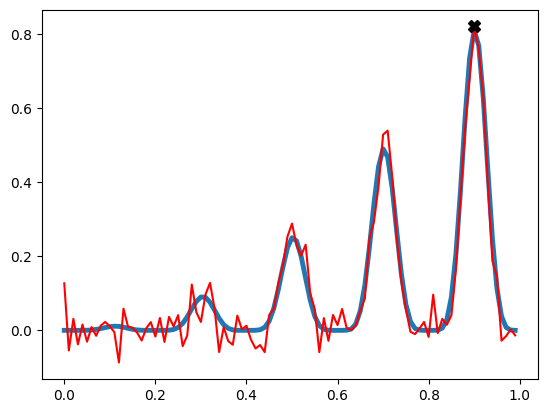

In [7]:
fig, ax = plt.subplots()
ax.plot(X,Y, linewidth=3.5)
ax.plot(X,y, color='red')
i = np.argmax(y)
ax.plot(X[i], y[i], 'kX', markersize=9)

In [8]:
with pm.Model() as model:
    
    η = 1
    ρ = 1
    
    μ = pm.gp.mean.Zero()
    K = η**2 * pm.gp.cov.Matern52(1, ρ)
    
    σ = pm.HalfNormal('σ', 1)
    
    costfunc = pm.gp.Marginal(mean_func=μ, cov_func=K)
    costfunc.marginal_likelihood('cost', X=X,
              y=y, noise=σ)
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=44)

/media/alexander-fyrogenis/Elements/Διδακτορικό/Olive Oil/notebooks/venv/lib/python3.10/site-packages/pymc/gp/gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 142 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6991, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
Xpred = np.arange(0,1,0.01)[:, np.newaxis]
Ytrue = objective(Xpred, noise=.04)
with model:
    Ypred = costfunc.conditional('Ypred', Xpred, pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(gp_trace,random_seed=44, var_names=['Ypred'])

Sampling: [Ypred]


In [10]:
from pymc.gp.util import plot_gp_dist

In [11]:
gp_samples

Inference data with groups:
	> posterior_predictive
	> observed_data

KeyError: 'Ypred'

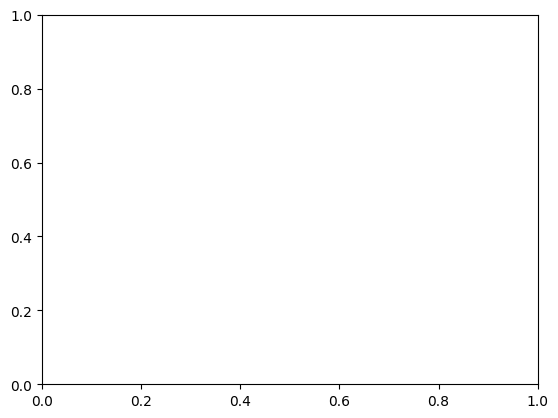

In [12]:
fig, ax = plt.subplots()
plot_gp_dist(ax, gp_samples['Ypred'], Xpred)
ax.scatter(X, y)